In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/batches.meta
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/test_batch
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/readme.html


In [35]:
import numpy as np
import pandas as pd
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch.optim.lr_scheduler import StepLR
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
# choose CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify the folder where the CIFAR-10 batch files are
cifar10_dir = '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py'

In [40]:
# Load the label names
#dict
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
#list
label_names = [x.decode('utf-8') for x in meta_data_dict[b'label_names']]
print(label_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [6]:
train_images = []
train_labels = []
for i in range(1, 6):
    batch = load_cifar_batch(os.path.join(cifar10_dir, f'data_batch_{i}'))
    batch_images = batch[b'data']
    batch_images = batch_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)
    train_images.append(batch_images)
    train_labels += batch[b'labels']
train_images = np.vstack(train_images)
train_labels = np.array(train_labels)

In [7]:
# Load validation batch
#dict
val_dict = load_cifar_batch(os.path.join(cifar10_dir, 'test_batch'))
#np array  shape: (10000, 3072)
val_images = val_dict[b'data']
#np array  shape: (10000, 32, 32, 3)
val_images = val_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)
#list
val_labels = val_dict[b'labels']

In [8]:
#Load Test Data
#dict
test_dict = load_cifar_batch('/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl')
# Extract images 
#np array shape: (10000, 32, 32, 3)
test_images = test_dict[b'data']
#np array  shape: (10000,)
test_ids = test_dict[b'ids']

In [9]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
train_data = [(transform(img), label) for img, label in zip(train_images, train_labels)]
val_data = [(transform(img), label) for img, label in zip(val_images, val_labels)]
test_data = [transform(img) for img in test_images]

train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=4)

Train Images


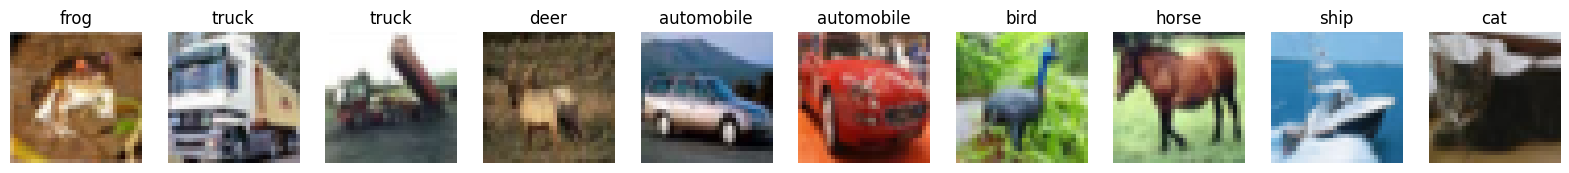

Validation Images


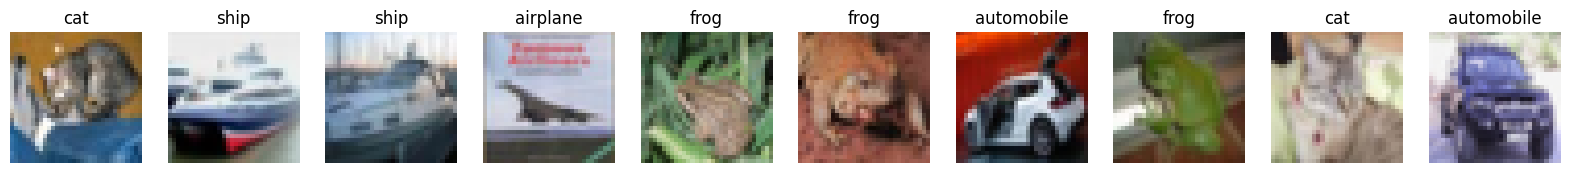

Test Images


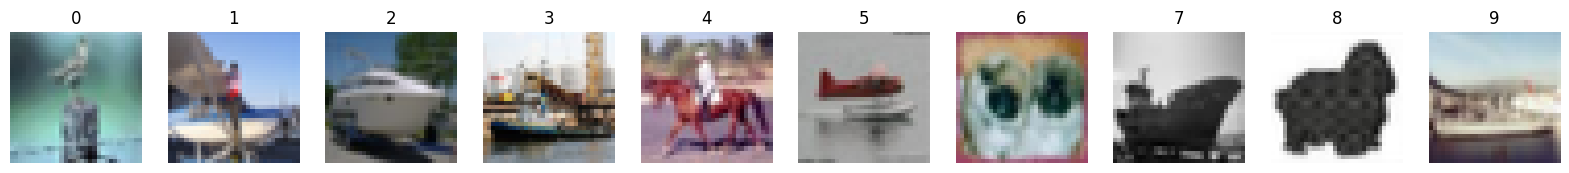

In [10]:
#Display the first 10 images and labels
print("Train Images")
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_images[i])
    plt.title(label_names[train_labels[i]].decode('utf-8'))  # Decoding from bytes to string
    plt.axis('off')
plt.show()

print("Validation Images")
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(val_images[i])
    plt.title(label_names[val_labels[i]].decode('utf-8'))  # Decoding from bytes to string
    plt.axis('off')
plt.show()

print("Test Images")
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(test_images[i+10])
    plt.title(test_ids[i])  # Decoding from bytes to string
    plt.axis('off')
plt.show()

In [29]:
def train_model(model, train_loader, val_loader, epochs=30):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr=0.001, weight_decay=1e-4)
    scheduler = scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    y_pred = []
    y_true = []

    for epoch in range(epochs):
        model.train()
        train_correct = 0
        training_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
        train_loss_history.append(training_loss/len(train_loader))
        train_acc_history.append(train_correct/len(train_loader.dataset))

        model.eval()
        val_correct = 0
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
            val_loss_history.append(val_loss/len(val_loader))
            val_acc_history.append(val_correct/len(val_loader.dataset))
        
        scheduler.step()
        print(f'Epoch {epoch+1}, Loss: {train_loss_history[-1]}, Validation Accuracy: {100 * val_acc_history[-1]}%')
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history, y_pred, y_true

In [20]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        identity = x 
        if self.skip:
            identity = self.skip(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

In [21]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()
        self.init_conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.init_bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(64, 64, 3, stride=1)
        self.layer2 = self._make_layer(64, 128, 3, stride=2)
        self.layer3 = self._make_layer(128, 256, 3, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.init_conv(x)
        out = self.init_bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        #out = self.layer4(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [26]:
model = CustomResNet().to(device)

from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
    ResidualBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

In [30]:
# Train the model
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
y_pred = []
y_true = []

train_loss_history, train_acc_history, val_loss_history, val_acc_history, y_pred, y_true = train_model(model, train_loader, val_loader, epochs=30)
torch.save(model.state_dict(), '/kaggle/working/my_model.pth')

Epoch 1, Loss: 1.0023650642856003, Validation Accuracy: 63.56%
Epoch 2, Loss: 0.779517687952427, Validation Accuracy: 71.98%
Epoch 3, Loss: 0.6432268147730766, Validation Accuracy: 75.47%
Epoch 4, Loss: 0.5515954443408401, Validation Accuracy: 74.51%
Epoch 5, Loss: 0.4789655880854868, Validation Accuracy: 73.72999999999999%
Epoch 6, Loss: 0.4181946871225791, Validation Accuracy: 78.64999999999999%
Epoch 7, Loss: 0.36137260389907283, Validation Accuracy: 80.97%
Epoch 8, Loss: 0.3191481951786124, Validation Accuracy: 79.57%
Epoch 9, Loss: 0.27694745009283883, Validation Accuracy: 83.28%
Epoch 10, Loss: 0.23858953253997256, Validation Accuracy: 80.36%
Epoch 11, Loss: 0.0956658107964584, Validation Accuracy: 87.02%
Epoch 12, Loss: 0.051814301172866846, Validation Accuracy: 86.92%
Epoch 13, Loss: 0.034449419247277104, Validation Accuracy: 86.83%
Epoch 14, Loss: 0.022348613783126445, Validation Accuracy: 86.83%
Epoch 15, Loss: 0.015037820863244516, Validation Accuracy: 86.82%
Epoch 16, Loss:

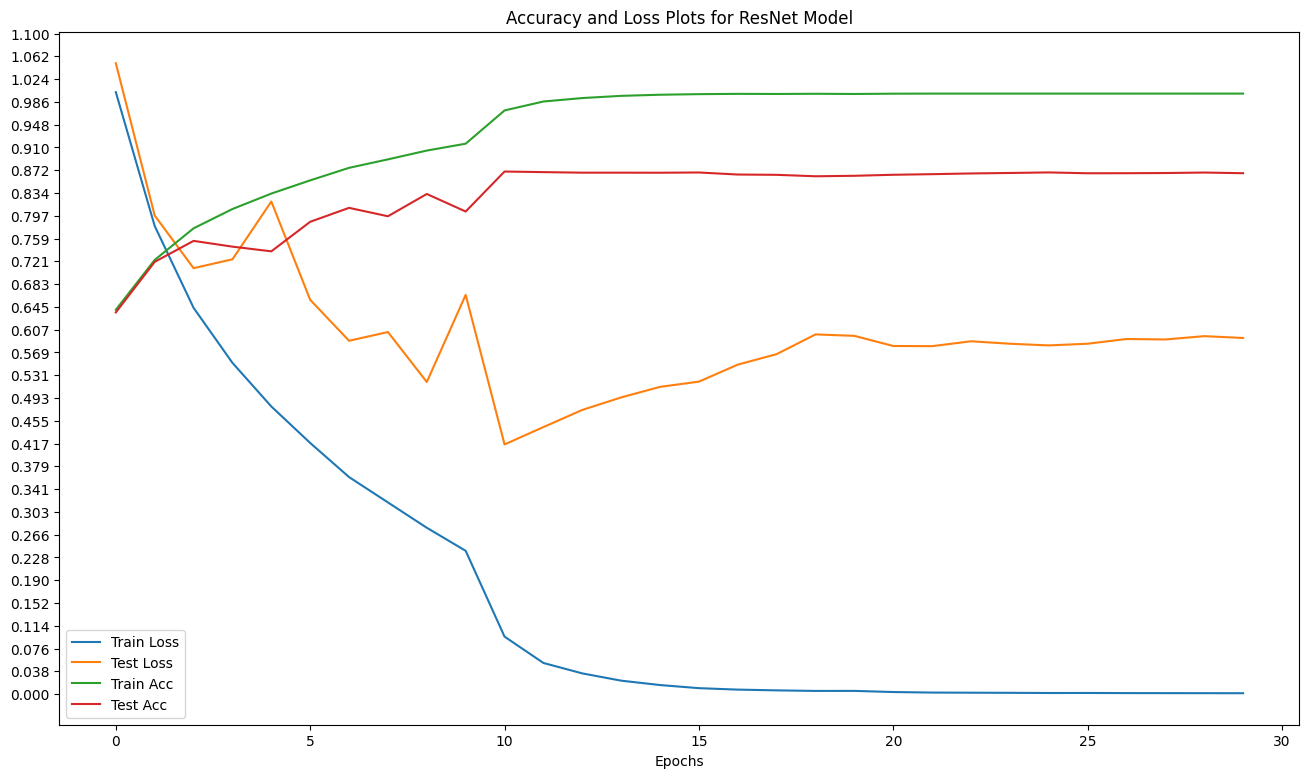

In [31]:
fig, ax = plt.subplots(figsize=(16,9))

plt.title('Accuracy and Loss Plots for ResNet Model')
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Test Loss')
plt.plot(train_acc_history, label='Train Acc')  
plt.plot(val_acc_history, label='Test Acc')
plt.legend()
plt.xlabel("Epochs")
yticks = np.linspace(0, 1.1, num=30)
ax.set_yticks(yticks)
plt.show()  

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'airplane'),
  Text(1, 0, 'automobile'),
  Text(2, 0, 'bird'),
  Text(3, 0, 'cat'),
  Text(4, 0, 'deer'),
  Text(5, 0, 'dog'),
  Text(6, 0, 'frog'),
  Text(7, 0, 'horse'),
  Text(8, 0, 'ship'),
  Text(9, 0, 'truck')])

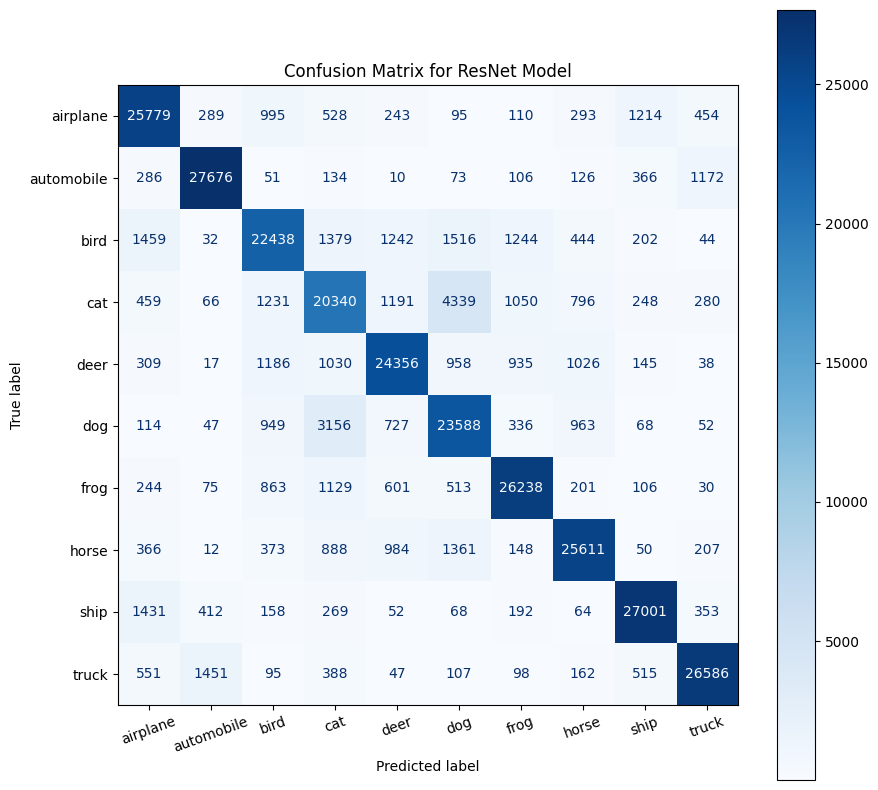

In [41]:
# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
fig = plt.figure(figsize = (10, 10));
ax = fig.add_subplot(1, 1, 1);
ax.set_title('Confusion Matrix for ResNet Model')
cm = ConfusionMatrixDisplay(cm, display_labels = label_names);
cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
plt.xticks(rotation = 20)

In [43]:
#print(f"{train_loss_history},{train_acc_history},{val_loss_history},{val_acc_history},{y_pred},{y_true}")

In [45]:
# Generate submission file
model.eval()
predictions = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images) 
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.cpu().numpy()
        predictions.extend(predicted)

submission = pd.DataFrame({'ID': np.arange(len(predictions)), 'Labels': predictions})
submission.to_csv('/kaggle/working/submission.csv', index=False)
print("Submission file saved.")

Submission file saved.
